In [1]:
import pandas as pd
import numpy as np
from scipy import sparse as sps
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## review data

In [3]:
saved = open("pickle/game_reviews.pickle","rb")
game_reviews = pickle.load(saved)
game_reviews.head()

,funny,helpful,item_id,last_edited,posted,recommend,review,user_id
0,,No ratings yet,1250,,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...,76561197970982479
1,,No ratings yet,22200,,"Posted July 15, 2011.",True,It's unique and worth a playthrough.,76561197970982479
2,,No ratings yet,43110,,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479
3,,15 of 20 people (75%) found this review helpful,251610,,"Posted June 24, 2014.",True,I know what you think when you see this title ...,js41637
4,,0 of 1 people (0%) found this review helpful,227300,,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...,js41637


In [4]:
game_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58430 entries, 0 to 58429
Data columns (total 8 columns):
funny          58430 non-null object
helpful        58430 non-null object
item_id        58430 non-null int64
last_edited    58430 non-null object
posted         58430 non-null object
recommend      58430 non-null bool
review         58430 non-null object
user_id        58430 non-null object
dtypes: bool(1), int64(1), object(6)
memory usage: 3.2+ MB


In [5]:
reviews = game_reviews[['item_id', 'user_id','review']]
reviews = reviews.rename(columns={'user_id': 'user', 'item_id': 'item'})
reviews.shape

(58430, 3)

In [6]:
reviews.loc[reviews['user'] == '76561197970982479']

,item,user,review
0,1250,76561197970982479,Simple yet with great replayability. In my opi...
1,22200,76561197970982479,It's unique and worth a playthrough.
2,43110,76561197970982479,Great atmosphere. The gunplay can be a bit chu...


## number of reviews

In [7]:
total_rev = len(reviews)
total_rev

58430

## number of unique users who wrote reviews

In [8]:
reviewers = len(set(reviews['user']))
reviewers

25457

## number of unique games that have reviews

In [9]:
rev_item = len(set(reviews['item']))
rev_item

3682

# User library

In [10]:
user_game = open("pickle/user_games.pickle","rb")
user_games = pickle.load(user_game)
user_games.head()

,user_id,item_id,item_name
0,76561197970982479,10,Counter-Strike
1,76561197970982479,20,Team Fortress Classic
2,76561197970982479,30,Day of Defeat
3,76561197970982479,40,Deathmatch Classic
4,76561197970982479,50,Half-Life: Opposing Force


In [11]:
user_games_list = user_games_list.rename(columns={'user_id': 'user', 'item_id': 'item'})
user_games_list = user_games[['item_id', 'user_id']]

user_games_list.head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


In [12]:
user_games_list.loc[user_games_list['user'] == '76561197970982479'].head()

,item,user
0,10,76561197970982479
1,20,76561197970982479
2,30,76561197970982479
3,40,76561197970982479
4,50,76561197970982479


## number od unique users

In [13]:
total_user = len(set(user_games_list['user']))
total_user

70912

## #unique item

In [14]:
total_item = len(set(user_games_list['item']))
total_item

10978

## Difference

## how many items in user list don't have reviews

In [15]:
not_rev_item = total_item - rev_item
not_rev_item

7296

### what fraction of items are not reviewed 

In [16]:
frac_not_rev = not_rev_item/total_item
frac_not_rev

0.6646019311349972

## how many user don't write review?

In [17]:
no_rev_user = total_user - reviewers
no_rev_user

45455

### what fraction of users don't write review?

In [18]:
frac_not_reviewers = no_rev_user/total_user
frac_not_reviewers

0.6410057536101083

### interesting difference: not all items in reviewed items are in user library

In [19]:
item_list = set(user_games_list['item'])
reviewed_item_list = set(reviews['item'])
rev_notin_lib = reviewed_item_list.difference(item_list)
len(rev_notin_lib)

361

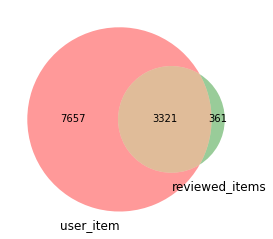

In [20]:
from matplotlib_venn import venn2, venn2_circles
set1 = set(user_games_list['item'])
set2 = set(reviews['item'])
venn2([set1, set2], ('user_item', 'reviewed_items'))

### in review table but not in user-item library

In [21]:
user_list = set(user_games_list['user'])
reviewers_list = set(reviews['user'])
rev_notin_userlib = reviewers_list.difference(user_list)
len(rev_notin_userlib)

2845

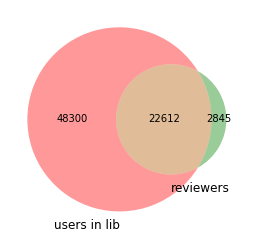

In [22]:
from matplotlib_venn import venn2, venn2_circles
set1 = set(user_games_list['user'])
set2 = set(reviews['user'])
venn2([set1, set2], ('users in lib', 'reviewers'))

# Count

In [24]:
def groupby_count(df, group, count):
    game_count = pd.DataFrame()
    game_count['count'] = df.groupby(group)[count].count()
    return game_count

### number of reviews per user

In [45]:
rev_per_user = groupby_count(reviews, 'user', 'review')
rev_per_user.sort_values(by='count', ascending = False).head(10)

,count
user,
76561198045431856,10
chicken_tonight,10
76561198048348337,10
registeredso,10
ItsDerRey,10
spicydoggomemes,10
76561198038741062,10
Slavishbear,10
chickenzrulz,10


In [47]:
user_rev_stat = rev_per_user.reset_index()
user_rev_count = groupby_count(user_rev_stat, 'count', 'user')
user_rev_count

,count
count,
1,13528
2,4629
3,2529
4,1499
5,980
6,736
7,551
8,419
9,324


### number of reviews per item

In [48]:
rev_per_item = groupby_count(reviews, 'item', 'review')
rev_per_item.sort_values(by='count', ascending = False).head(10)

,count
item,
287100,1
286971,1
286660,1
286260,1
285820,1
285740,1
285500,1
285480,1
285440,1


In [ ]:
item_rev_stat = rev_per_item.reset_index()
item_rev_count = groupby_count(item_rev_stat, 'count', 'item')
item_rev_count

### #games per user

In [27]:
item_per_user = groupby_count(user_games_list, 'user', 'item')
item_per_user.sort_values(by='count', ascending = False).head(10)

,count
user,
phrostb,7762
thugnificent,6700
chidvd,6410
piepai,6132
mayshowganmore,5027
DeEggMeister,4576
76561198070585472,4456
Steamified,4432
rawrvixen,4212


## #user per game

In [28]:
user_per_item = groupby_count(user_games_list, 'item', 'user')
user_per_item.sort_values(by='count', ascending = False).head(10)

,count
item,
205790,49136
730,43331
4000,42849
304930,38278
550,36661
223530,36661
105600,28934
230410,25516
620,24206


### join